# Bibliotheken

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.base import BaseEstimator, TransformerMixin
from pipe_tools.pipe_visualizer import plot_pipeline

# Daten Laden
Hier werden die Daten geladen, Die Spalten benant, die im DAtensatz ? für missings durch np.nansersetzt und zueltzt eingie Datentypen auf konvertiert.

In [2]:
labelList=['symboling','normalizedLosses','make','fuelType','aspiration','numOfDoors','bodyStyle','driveWheels','engineLocation',
           'wheelBase','length','width','height','curbWeight','engineType','numOfCylinders','engineSize','fuelSystem','bore',
           'stroke','compressionRatio','horsepower','peakRpm','cityMpg','highwayMpg','price']
df = pd.read_csv('../data/data_car-CopyForEDA.csv',delimiter=',',encoding='utf-8', names=labelList)
# Datentypen umwandeln & ? durch np.NAN ersetzen
df = df.replace("?", np.nan)
df[['normalizedLosses']]=df[['normalizedLosses']].astype('category') #
df[['price']]=df[['price']].astype('float64')
df[['horsepower']]=df[['horsepower']].astype('float64')
df[['peakRpm']]=df[['peakRpm']].astype('float64')
df[['bore']]=df[['bore']].astype('float64')
df[['stroke']]=df[['stroke']].astype('float64')
df[['engineSize']]=df[['engineSize']].astype('float64')
df[['cityMpg']]=df[['cityMpg']].astype('float64')
df[['highwayMpg']]=df[['highwayMpg']].astype('float64')
df[['curbWeight']]=df[['curbWeight']].astype('float64')

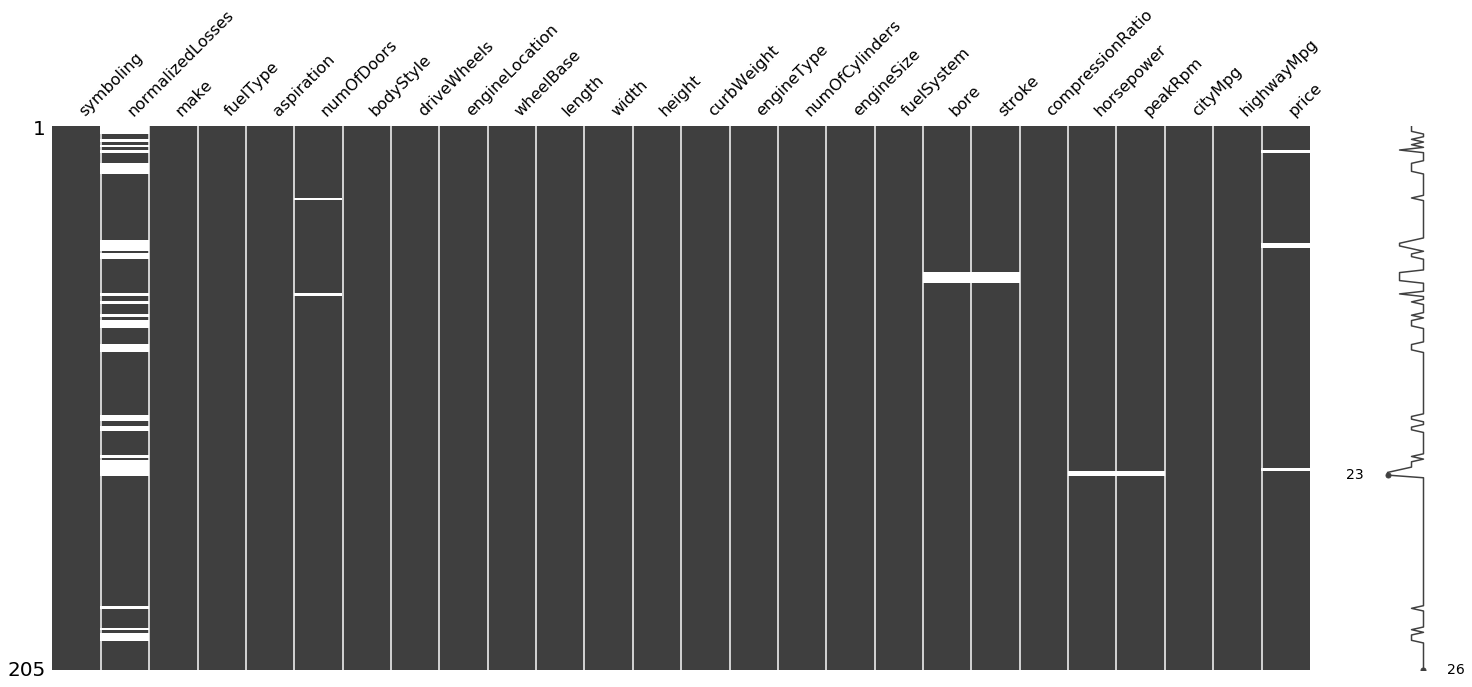

In [3]:
# show all nan-Values
msno.matrix(df)

# horizontaler und vertikaler Cut

# Helper-Function

In [4]:
def debug_print(X, debug):
    """This method prints some debug information based on a debug parameter."""
    if not debug in ["input", "shape", "columns", False]:
        raise ValueError("Debug parameter value is not valied.")
    elif debug=="input":
        print(X.head(5))
    elif debug=="shape":
        print(X.shape)
    elif debug=="columns":
        print(X.columns)
    elif debug is False:
        pass

# Selectoren

## Column-Selector

In [5]:
from sklearn.pipeline import Pipeline
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

## Type-Selector

In [6]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

# Custom Estimatoren

In [7]:
class PriceImputer():
    """Imputs Price with median price of car-Brand."""

    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df.price = df.groupby(['make'])['price'].apply(lambda x: x.fillna(x.median()))
        self.colnames = df.columns.tolist()
        return df
    
    def get_feature_names(self):
        return self.colnames 

In [8]:
class numOfDoorsImputer():
    
    """Imputs numOfDoor with modus of body-Style."""
    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        debug_print(X=X, debug=self.d)
        #df = X.copy()

        df.numOfDoors = df.groupby(['bodyStyle'])['numOfDoors'].apply(lambda x: x.fillna(x.mode().iloc[0]))
        self.colnames = df.columns.tolist()
        return df
    
    def get_feature_names(self):
        return self.colnames 

In [9]:
class boreStrokeImputer():
    """Imputs bore & Stroke with value of the next smaller engine size."""
    """Im gegebenen Datensatz sind die die Instanzen, welche nan/0/whatever in bore haben, die gleichen, die auch 
    missings in stroke haben. Auch wenn es gegen alle guten Sitten verstößt habe ich hier somit zwei feature zeitgleich upgedatet"""
    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        debug_print(X=X, debug=self.d)
        #df = X.copy()
        ##########
        for i in range(0, len(df.stroke),1):
            if(str(df.stroke[i]) == "nan"):
                refferenceEngine = df.engineSize[i]
                possibleMachines = []
                for j in range(0, len(df),1):
                    if(df.engineSize[j]<refferenceEngine):
                        possibleMachines.append([j, df.engineSize[j], df.bore[j], df.stroke[j]])
                    else:
                        pass
                detectedValue=[possibleMachines[0]]# finde aus den möglichen Maschinen, die nächst kleinere im vgl zu unserem nan wert
                for j in range(0, len(possibleMachines),1):
                    if(int(detectedValue[0][1]) >= int(possibleMachines[j][1])):
                        pass
                    else:
                        detectedValue = [possibleMachines[j]]
                df.bore[i] = detectedValue[0][2]
                df.stroke[i] = detectedValue[0][3]
            
        ##########
        return df
    
    def get_feature_names(self):
        return self.colnames 


In [10]:
class hpPRPMImputer():
    """Imputs horspower & PRPM with value of the next smaller engine size."""
    """Im gegebenen Datensatz sind die die Instanzen, welche nan/0/whatever in HP haben, die gleichen, die auch 
    missings in PRPM haben. Auch wenn es gegen alle guten Sitten verstößt habe ich hier somit zwei feature zeitgleich upgedatet"""
    "'horsepower','peakRpm"
    
    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        debug_print(X=X, debug=self.d)
        ##########
        for i in range(0, len(df.stroke),1):
            if(str(df.horsepower[i]) == "nan"):
                refferenceEngine = df.engineSize[i]
                possibleMachines = []
                for j in range(0, len(df),1):
                    if(df.engineSize[j]<refferenceEngine):
                        possibleMachines.append([j, df.engineSize[j], df.horsepower[j], df.peakRpm[j]])
                    else:
                        pass
                detectedValue=[possibleMachines[0]]# finde aus den möglichen Maschinen, die nächst kleinere im vgl zu unserem nan wert
                for j in range(0, len(possibleMachines),1):
                    if(int(detectedValue[0][1]) >= int(possibleMachines[j][1])):
                        pass
                    else:
                        detectedValue = [possibleMachines[j]]
                df.horsepower[i] = detectedValue[0][2]
                df.peakRpm[i] = detectedValue[0][3]
            
        ##########
        return df
    
    def get_feature_names(self):
        return self.colnames 

In [11]:
class OHE():
    """OHE on the Object-Variables"""

    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        interimLabelListdf = X.select_dtypes(include='object')
        interimLabelList = list(interimLabelListdf.columns)
        ohe = OneHotEncoder(sparse=False)
        npArray = ohe.fit_transform(X[interimLabelList])
        titles = []
        for singleList in ohe.categories_:
            titles = titles + list(singleList)
        interimDF = pd.DataFrame(data = npArray, columns=titles)
        df = pd.concat([X, interimDF], axis=1, sort=False)
        for i in range(0,len(interimLabelList),1):
            df = df.drop([interimLabelList[i]], axis=1)
            #train_X = train_X.drop(['normalizedLosses'], axis=1)
        return df
    
    
    def get_feature_names(self):
        return self.colnames 

In [12]:
from sklearn.preprocessing import RobustScaler

class CustomRobustScaler:
    def __init__(self, debug=False, strategy="median"):
        self._scaler = None
        self._column_list=[]
        self.d = debug
        self.colnames = None

    def fit(self, X, y=None):
        self._scaler = RobustScaler()
        self._scaler.fit(X)
        return self

    def transform(self, X):
        interimLabelList = ['wheelBase','length','width','height','curbWeight','engineSize','bore','stroke','compressionRatio','horsepower','peakRpm','cityMpg','highwayMpg','price']
        X_interim = X[interimLabelList].to_numpy()
        print(type(X_interim))
        transformer = RobustScaler().fit(X_interim)
        transformer.transform(X_interim)
        print(X_interim)
        
        
    def get_feature_names(self):
        return self.colnames

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

class RegressionImputation:
    """The last Section with NANs is normalizedLosses. We will impute this by Bayesian-Rdige """
    def __init__(self, debug=False, strategy="median"):
        self._scaler = None
        self._column_list=[]
        self.d = debug
        self.colnames = None

    def fit(self, X, y=None):
        self._scaler = RobustScaler()
        self._scaler.fit(X)
        return self

    def transform(self, X):
        interimLabelList = list(X.columns)
        #print(interimLabelList)
        x_interim = X.to_numpy()
        print(x_interim)
        #print(type(x_interim))
        imputer = IterativeImputer(BayesianRidge())
        impute_data = pd.DataFrame(imputer.fit_transform(x_interim),  columns=interimLabelList)
        return(impute_data)
 
    def get_feature_names(self):
        return self.colnames

# Pipeline

In [14]:
from sklearn.pipeline import Pipeline

class FeaturePipeline(Pipeline):
    def get_feature_names(self):
        return self.steps[-1][1].get_feature_names()

In [15]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

debug_state = False

pipe = FeaturePipeline(
    [

        ("price_imputation", PriceImputer(debug=False)),
        ("numOfDoors_imputation", numOfDoorsImputer(debug=False)),
        ("boreAndStroke_imputation", boreStrokeImputer(debug=False)),
        ("hpPRPM_imputation", hpPRPMImputer(debug=False)),
        ("OHE", OHE(debug=False)), 
        ("ImputationNormalizedLosses", RegressionImputation(debug=False)),
        #("Robust-Scaler", CustomRobustScaler(debug=False)),
        
    ]
)

In [16]:
#train_X = train_X.drop(['normalizedLosses'], axis=1)

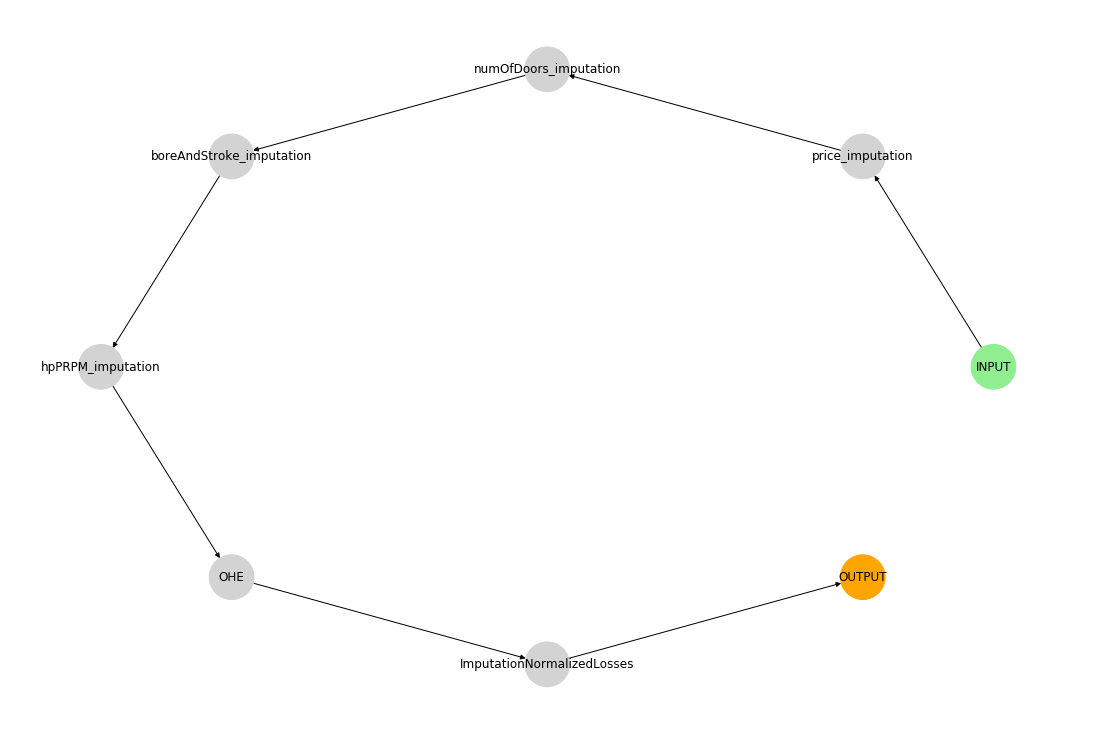

In [17]:
plot_pipeline(pipe, "pipeline_plot.png")

In [18]:
print(df.shape)

(205, 26)


In [19]:
#from sklearn.experimental import enable_iterative_imputer
df_prepared = pipe.fit(df)
df_prepared = pipe.transform(df)

C:\Users\1810837475\.conda\envs\Kompensationsarbeit\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\1810837475\.conda\envs\Kompensationsarbeit\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\1810837475\.conda\envs\Kompensationsarbeit\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[3 nan 88.6 ... 1.0 0.0 0.0]
 [3 nan 88.6 ... 1.0 0.0 0.0]
 [1 nan 94.5 ... 1.0 0.0 0.0]
 ...
 [-1 '95' 109.1 ... 1.0 0.0 0.0]
 [-1 '95' 109.1 ... 0.0 0.0 0.0]
 [-1 '95' 109.1 ... 1.0 0.0 0.0]]


In [20]:
print(df_prepared.shape)

(205, 76)


(205, 76)


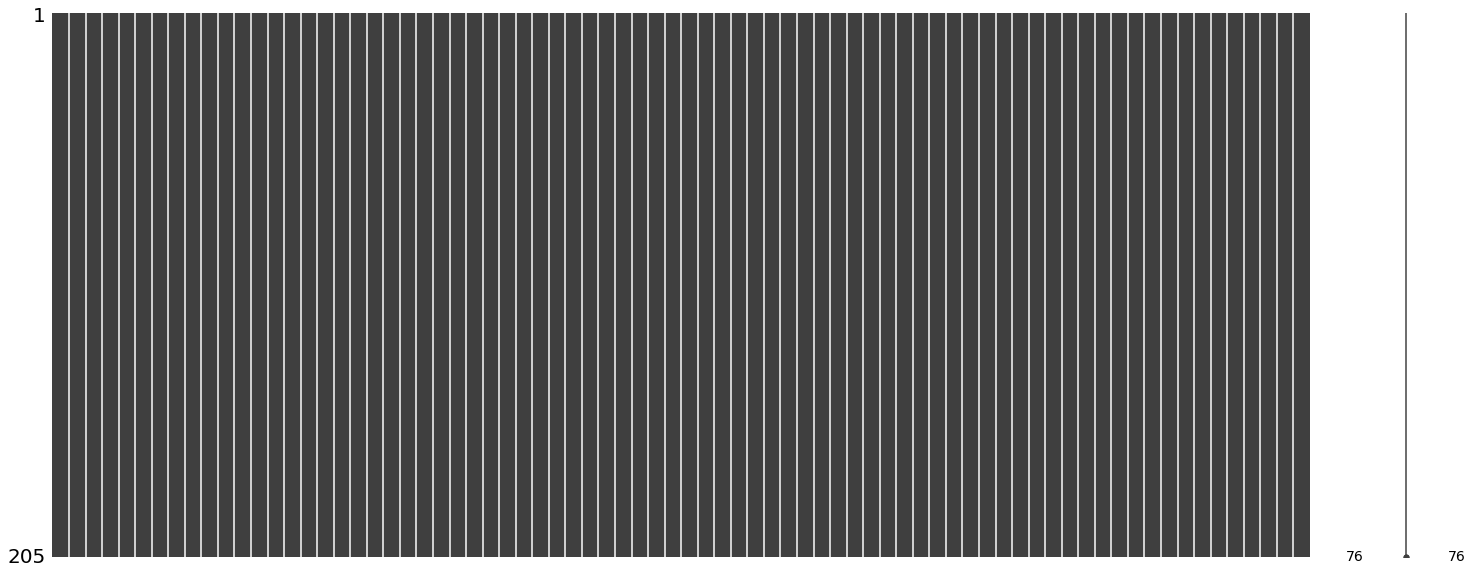

In [21]:
msno.matrix(df_prepared)
print(df_prepared.shape)

# Write to Folder Data

In [22]:
df_prepared.to_csv(r'../data/reg_df_prepared.csv')

In [23]:
df_prepared.isna().any().any()

False